In [15]:
from fastai.vision.all import *
from tqdm import tqdm
from torch.utils.data import Dataset

In [2]:
DATA_PATH = Path('data')
TRAIN_PATH = DATA_PATH / 'train_features'
LABEL_PATH = DATA_PATH / 'train_labels'

In [3]:
df = pd.read_csv(DATA_PATH / 'train_ready.csv')

In [4]:
df.head(1)

,chip_id,location,datetime,cloudpath,is_valid,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,False,data/train_features/adwp/B02.tif,data/train_features/adwp/B03.tif,data/train_features/adwp/B04.tif,data/train_features/adwp/B08.tif,data/train_labels/adwp.tif


In [5]:
IMG_SIZE = 512
BS = 3

In [7]:
def get_array(chip, band):
    fn = (TRAIN_PATH / chip /band).with_suffix('.tif')
    if fn.exists():
        return (np.array(Image.open(fn)) / 27000)
    else:
        return np.zeros((512, 512))

def get_4chan(chip_folder):
    blue  = get_array(chip_folder, 'B02')
    green = get_array(chip_folder, 'B03')
    red   = get_array(chip_folder, 'B04')
    infra = get_array(chip_folder, 'B08')
    
    stack = np.stack([blue, green, red, infra], axis = -1) 
    return stack

def get_mask(chip):
    fn = (LABEL_PATH / chip).with_suffix('.tif')
    return tensor(np.array(Image.open(fn))).long()

def get_chips(path):
    potential_chips = list(path.iterdir())
    chips_paths = L(chip for chip in potential_chips if chip.is_dir())
    return chips_paths.attrgot('name')

def is_valid(chip):
    return df.loc[df['chip_id'] == chip, 'is_valid'].item()

---
## <Datasets
---

In [28]:
set([1,2,3]).intersection(set([2,3,4]))

{2, 3}

In [29]:
class Chips:
    def __init__(self, src_path, df):
        self.src_path = src_path
        self.names = self.get_chips(src_path)
        self.df = df
        self.train_idx = self.names.argwhere(self.is_valid, negate = True)
        self.valid_idx = self.names.argwhere(self.is_valid)
        assert(len(self.train_idx) + len(self.valid_idx) == len(self.names))
        assert(len(set(self.train_idx).intersection(set(self.valid_idx))) == 0)
    
    def is_valid(self, chip):
        return self.df.loc[self.df['chip_id'] == chip, 'is_valid'].item()
    
    @staticmethod
    def get_chips(path):
        potential_chips = list(path.iterdir())
        chips_paths = L(chip for chip in potential_chips if chip.is_dir())
        return chips_paths.attrgot('name')
    
    def describe(self):
        print(f'Number of validation items: {len(self.valid_idx)}, number of training items: {len(self.train_idx)}\nTotal number of items: {len(self.names)}')
        
    def get_train_chips(self):
        return self.names[self.train_idx]
    
    def get_valid_chips(self):
        return self.names[self.valid_idx]

In [30]:
chips = Chips(TRAIN_PATH, df)
chips.describe()

Number of validation items: 2442, number of training items: 9306
Total number of items: 11748


In [16]:
class multi_channel_ds(Dataset):
    def __init__(self, 
                 features_path,
                 labels_path,
                 chips, 
                 n_channels, 
                 img_transforms=None, 
                 mask_transforms=None
                ):
        self.features_path = features_path
        self.labels_path  = labels_path
        self.files = chips
        self.df = df
        self.n_channels = n_channels
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        chip = self.files[idx]
        img = tensor(self.get_4chan(chip)).float()
        mask = tensor(self.get_mask(chip)).long()
        return img, mask
      
    def get_array(self, chip, band):
        fn = (self.train_path / chip / band).with_suffix('.tif')
        if fn.exists():
            return (np.array(Image.open(fn)) / 27000)
        else:
            return np.zeros((512, 512))
    
    @staticmethod
    def get_4chan(chip):
        blue  = get_array(chip, 'B02')
        green = get_array(chip, 'B03')
        red   = get_array(chip, 'B04')
        infra = get_array(chip, 'B08')

        stack = np.stack([blue, green, red, infra], axis = 0) ## to -1 if transforms are expectod
        return stack
    
    def get_mask(self, chip):
        fn = (self.labels_path / chip).with_suffix('.tif')
        return np.array(Image.open(fn))
    
    @staticmethod
    def get_chips(path):
        potential_chips = list(path.iterdir())
        chips_paths = L(chip for chip in potential_chips if chip.is_dir())
        return chips_paths.attrgot('name')

In [24]:
train_ds = multi_channel_ds(
    features_path = TRAIN_PATH, 
    labels_path = LABEL_PATH, 
    chips = chips.get_train_chips(),
    n_channels = 4
)

valid_ds = multi_channel_ds(
    features_path = TRAIN_PATH,
    labels_path = LABEL_PATH,
    chips = chips.get_valid_chips(),
    n_channels = 4
)

In [31]:
train_dl = DataLoader(train_ds, batch_size = BS, shuffle = True, num_workers = 6, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size = BS, shuffle = False, num_workers = 6, pin_memory = True)

In [32]:
dls = DataLoaders(train_dl, valid_dl)

In [33]:
b = dls.one_batch()
print(b[0].shape, b[1].shape)

torch.Size([3, 4, 512, 512]) torch.Size([3, 512, 512])


---
## Datasets>
---
## <Transformations
---

---
## Transformations>
---
## <DataLoaders

In [ ]:
#class EmptyBlock(TransformBlock):
#    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
#        super().__init__(type_tfms=type_tfms, item_tfms=item_tfms, batch_tfms=batch_tfms, dl_type=dl_type, dls_kwargs=dls_kwargs)
#        self.item_tfms = L(item_tfms)
#        
#Simple4Chan = EmptyBlock(type_tfms = get_4chan)
#FourChanImageBlock = TransformBlock(type_tfms = get_4chan, batch_tfms = IntToFloatTensor)
#
#db = DataBlock(
#    blocks = (FourChanImageBlock, MaskBlock),
#    get_x = ColReader('chip_id', pref = img_path),
#    get_y = ColReader('label_path'),
#    splitter = ColSplitter(),
#    #item_tfms = Resize(IMG_SIZE),
#    batch_tfms = setup_aug_tfms([#Rotate(), 
#                                 RandomResizedCropGPU(IMG_SIZE, min_scale = 0.3), 
#    #                             #Brightness(0.3), 
#    #                             #Contrast(0.3), 
#    #                             #Hue(), 
#    #                             #Saturation(0.3)
#                                ])
#)
#
#dls = db.dataloaders(df, bs = 3)
#
#dls.show_batch()

In [34]:
img_size = dls.one_batch()[0].shape[-2:]

model = create_unet_model(
    arch = resnet34,
    n_out = 2,
    img_size = img_size,
    n_in = dls.n_channels
)

_default_meta    = {'cut':None, 'split':default_split}
meta = model_meta.get(resnet34, _default_meta)

learn = Learner(
    dls,
    model,
    loss_func = CrossEntropyLossFlat(axis = 1),
    metrics = [Dice, JaccardCoeff],
    splitter = meta['split']
)

learn.freeze()

---

SuggestedLRs(valley=0.0003311311302240938)

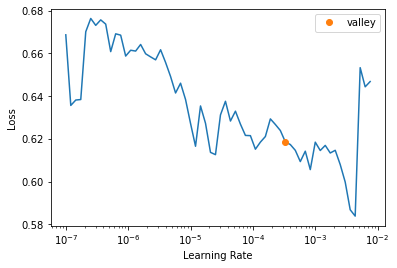

In [35]:
learn.lr_find()

In [ ]:
learn.fine_tune(5, 1e-4)

In [ ]:
#result_metric = None
#learn.export(f'res34_{IMG_SIZE}_j{result_metric}')